In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors 
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import silhouette_samples,calinski_harabasz_score,davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate 
from collections import Counter

%matplotlib inline


In [2]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
# Configure Seaborn plot styles: Set background color and use dark grid

sns.set(rc={'axes.facecolor':'#fcf0dc'},style="darkgrid")

In [4]:
#load dataset 
df=pd.read_csv("Data/data.csv", encoding="ISO-8859-1")

In [5]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.shape

(541909, 8)

Dataset Description:

1.InvoiceNo:	Code representing each unique transaction. If this code starts with letter 'c', it indicates a cancellation.

2.StockCode:	Code uniquely assigned to each distinct product.

3.Description:	Description of each product.

4.Quantity:	The number of units of a product in a transaction.

5.InvoiceDate: The date and time of the transaction.

6.UnitPrice:	The unit price of the product in sterling.

7.customerID:	Identifier uniquely assigned to each customer.

8.Country: The country of the customer.

In [7]:
#initial analaysis 

df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Inferences:

The dataset consists of 541,909 entries and 8 columns. Here is a brief overview of each column:

InvoiceNo: This is an object data type column that contains the invoice number for each transaction. Each invoice number can represent multiple items purchased in a single transaction.

StockCode: An object data type column representing the product code for each item.

Description: This column, also an object data type, contains descriptions of the products. It has some missing values, with 540,455 non-null entries out of 541,909.

Quantity: This is an integer column indicating the quantity of products purchased in each transaction.

InvoiceDate: A datetime column that records the date and time of each transaction.

UnitPrice: A float column representing the unit price of each product.

CustomerID: A float column that contains the customer ID for each 

transaction. This column has a significant number of missing values, with only 406,829 non-null entries out of 541,909.

Country: An object column recording the country where each transaction took place.

From a preliminary overview, it seems that there are missing values in the Description and CustomerID columns which need to be addressed. The InvoiceDate column is already in datetime format, which will facilitate further time series analysis. We also observe that a single customer can have multiple transactions as inferred from the repeated CustomerID in the initial rows.

The next steps would include deeper data cleaning and preprocessing to handle missing values, potentially erroneous data, and to create new features that can help in achieving the project goals.

In [9]:
#summary statistics for numerical value 

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [10]:
#summary statistics for categorical variables 

df.describe(include="object").T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


Inferences:

Quantity:

The average quantity of products in a transaction is approximately 9.55.

The quantity has a wide range, with a minimum value of -80995 and a maximum value of 80995. The negative values indicate returned or cancelled orders, which need to be handled appropriately.

The standard deviation is quite large, indicating a significant spread in the data. The presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.

UnitPrice:

The average unit price of the products is approximately 4.61.

The unit price also shows a wide range, from -11062.06 to 38970, which suggests the presence of errors or noise in the data, as negative prices don't make sense.

Similar to the Quantity column, the presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.

CustomerID:

There are 406829 non-null entries, indicating missing values in the dataset which need to be addressed.

The Customer IDs range from 12346 to 18287, helping in identifying unique customers.

InvoiceNo:

There are 25900 unique invoice numbers, indicating 25900 separate transactions.

The most frequent invoice number is 573585, appearing 1114 times, possibly representing a large transaction or an order with multiple items.

StockCode:

There are 4070 unique stock codes representing different products.

The most frequent stock code is 85123A, appearing 2313 times in the dataset.

Description:

There are 4223 unique product descriptions.

The most frequent product description is "WHITE HANGING HEART T-LIGHT HOLDER", appearing 2369 times.

There are some missing values in this column which need to be treated.

Country:

The transactions come from 38 different countries, with a dominant majority of the transactions (approximately 91.4%) originating from the United Kingdom.

**Data Cleaning & Transformation**

In [11]:
#calculete the percentage of missing value foe each column 

missing_data=df.isnull().sum()

missing_percentage= (missing_data[missing_data>0]/df.shape[0])*100

missing_percentage.sort_values(ascending=True, inplace=True)

missing_percentage

Description     0.268311
CustomerID     24.926694
dtype: float64

In [12]:
missing_percentage.index

Index(['Description', 'CustomerID'], dtype='object')

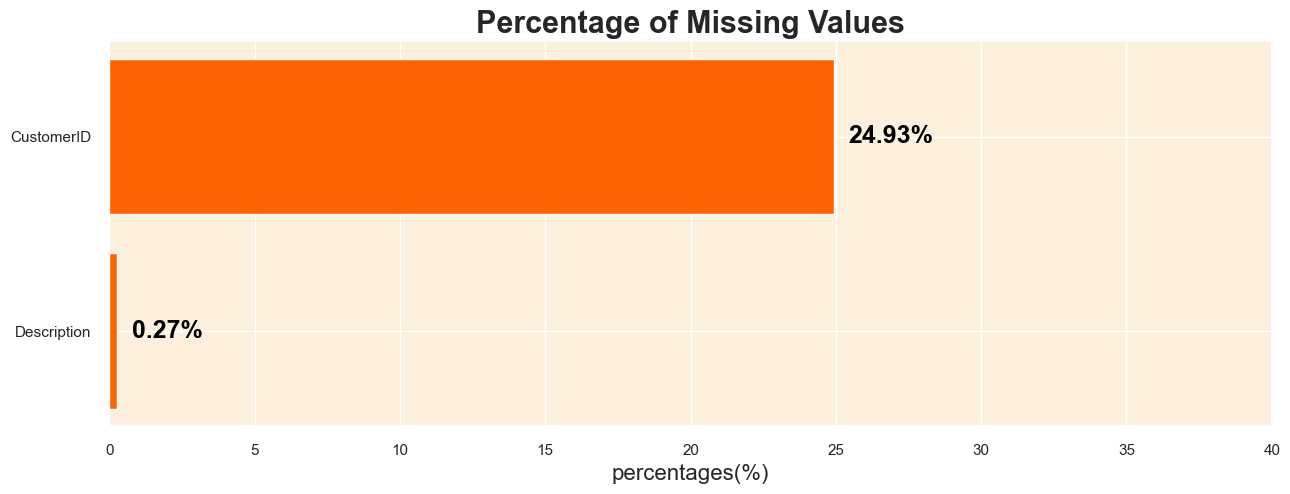

In [13]:
#Plot the barh chart 

fig,ax=plt.subplots(figsize=(15,5))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

for i, (value, name)in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha="left", va="center",fontweight='bold',
    fontsize=18, color='black')

ax.set_xlim([0,40])

plt.title("Percentage of Missing Values", fontweight="bold",fontsize=22)
plt.xlabel('percentages(%)',fontsize=16)
plt.show()

Handling Missing Values Strategy:

CustomerID (24.93% missing values)

The CustomerID column contains nearly a quarter of missing data. This column is essential for clustering customers and creating a recommendation system. Imputing such a large percentage of missing values might introduce significant bias or noise into the analysis.

Moreover, since the clustering is based on customer behavior and preferences, it's crucial to have accurate data on customer identifiers. Therefore, removing the rows with missing CustomerIDs seems to be the most reasonable approach to maintain the integrity of the clusters and the analysis.

Description (0.27% missing values)

The Description column has a minor percentage of missing values. However, it has been noticed that there are inconsistencies in the data where the same StockCode does not always have the same Description. This indicates data quality issues and potential errors in the product descriptions.

Given these inconsistencies, imputing the missing descriptions based on StockCode might not be reliable. Moreover, since the missing percentage is quite low, it would be prudent to remove the rows with missing Descriptions to avoid propagating errors and inconsistencies into the subsequent analyses.

By removing rows with missing values in the CustomerID and Description columns, we aim to construct a cleaner and more reliable dataset, which is essential for achieving accurate clustering and creating an effective recommendation system.

In [14]:
# Extracting rows with missing values in 'CustomerID' or 'Description' columns
df[df["CustomerID"].isnull()| df["Description"].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [15]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df=df.dropna(subset=['CustomerID',"Description"])

In [16]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [17]:
# Handling Duplicate values

duplicate_rows=df[df.duplicated(keep=False)]
duplicate_rows_sorted=duplicate_rows.sort_values(by=["InvoiceNo","StockCode","Description","CustomerID","Quantity"])

duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


Handling Duplicates Strategy:
In the context of this project, the presence of completely identical rows, including identical transaction times, suggests that these might be data recording errors rather than genuine repeated transactions. Keeping these duplicate rows can introduce noise and potential inaccuracies in the clustering and recommendation system.

Therefore, I am going to remove these completely identical duplicate rows from the dataset. Removing these rows will help in achieving a cleaner dataset, which in turn would aid in building more accurate customer clusters based on their unique purchasing behaviors. Moreover, it would help in creating a more precise recommendation system by correctly identifying the products with the most purchases.

In [18]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicate rows that need to be removed.


In [19]:
df.shape

(401604, 8)

In [20]:
#Treating Cancelled Transactions

df[df["InvoiceNo"].astype(str).str.startswith("C")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [21]:
df["Transaction_status"]=np.where(df["InvoiceNo"].astype(str).str.startswith('C'),'Cancelled',"Completed")



#cancelled_tranasctions.describe().drop("CustomerID",axis=1)

In [22]:
cancelled_transaction=df[df["Transaction_status"]=="Cancelled"]

cancelled_transaction.describe().drop("CustomerID",axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


Inferences from the Cancelled Transactions Data:

All quantities in the cancelled transactions are negative, indicating that these are indeed orders that were cancelled.

The UnitPrice column has a considerable spread, showing that a variety of products, from low to high value, were part of the cancelled transactions.


Strategy for Handling Cancelled Transactions:

Considering the project's objective to cluster customers based on their purchasing behavior and preferences and to eventually create a recommendation system, it's imperative to understand the cancellation patterns of customers. Therefore, the strategy is to retain these cancelled transactions in the dataset, marking them distinctly to facilitate further analysis. This approach will:

Enhance the clustering process by incorporating patterns and trends observed in cancellation data, which might represent certain customer behaviors or preferences.

Allow the recommendation system to possibly prevent suggesting products that have a high likelihood of being cancelled, thereby improving the quality of recommendations.


In [23]:
cancelled_percentage=(cancelled_transaction.shape[0]/df.shape[0])*100

print(f"The percentage of cancelled transaction in the dataset is :{cancelled_percentage: .2f}%")

The percentage of cancelled transaction in the dataset is : 2.21%


**Stock code Anomalies**

First of all, lets find the number of unique stock codes and to plot the top 10 most frequent stock codes along with their percentage frequency:

In [24]:
unique_stock_code=df["StockCode"].nunique()

print(f'The number of unique stock codes in the dataset is : {unique_stock_code}')


The number of unique stock codes in the dataset is : 3684


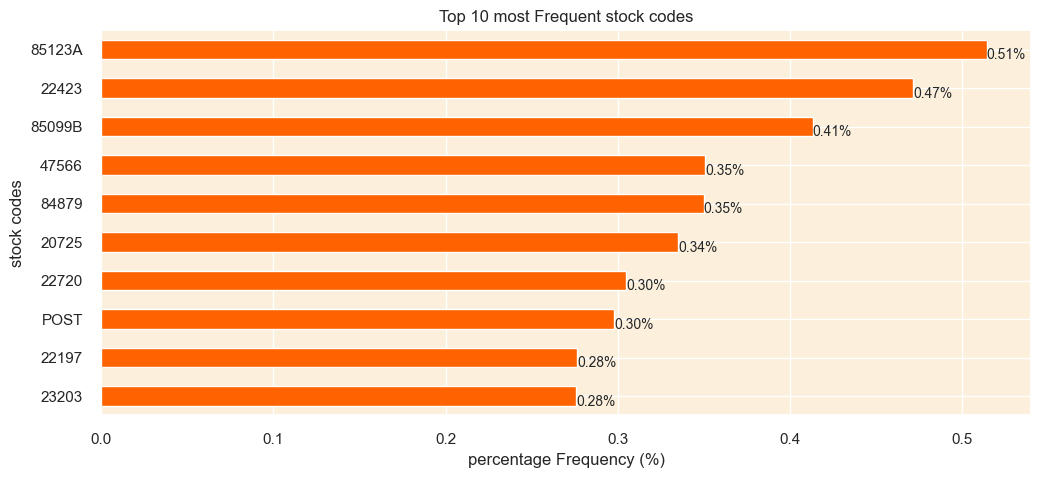

In [25]:
#finding the top 10 most frequent stock count
top_10_stock_codes=df["StockCode"].value_counts(normalize=True).head(10)*100

plt.figure(figsize=(12,5))
top_10_stock_codes.plot(kind="barh",color='#ff6200')

for index,value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%',fontsize=10)

plt.title('Top 10 most Frequent stock codes')
plt.xlabel("percentage Frequency (%)")
plt.ylabel("stock codes")
plt.gca().invert_yaxis()
plt.show()


Inferences on Stock Codes:

Product Variety: The dataset contains 3684 unique stock codes, indicating a substantial variety of products available in the online retail store. This diversity can potentially lead to the identification of distinct customer clusters, with preferences for different types of products.
Popular Items: A closer look at the top 10 most frequent stock codes can offer insights into the popular products or categories that are frequently purchased by customers.

Stock Code Anomalies: We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'POST'. These anomalies might represent services or non-product transactions (perhaps postage fees) rather than actual products. To maintain the focus of the project, which is clustering based on product purchases and creating a recommendation system, these anomalies should be further investigated and possibly treated appropriately to ensure data integrity.

To delve deeper into identifying these anomalies, let's explore the frequency of the number of numeric characters in the stock codes, which can provide insights into the nature of these unusual entries:

In [26]:
#find the number of numeric characters in each unique stock code 

unique_stock_codes=df["StockCode"].unique()

numeric_character_counts= pd.Series(unique_stock_codes).apply(lambda x:
sum(c.isdigit() for c in str(x))).value_counts()

print("value Counts for numeric characters frequencies in  unique codes")

print("--"*20)
print(numeric_character_counts)

value Counts for numeric characters frequencies in  unique codes
----------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


The output indicates the following:

A majority of the unique stock codes (3676 out of 3684) contain exactly 5 numeric characters, which seems to be the standard format for representing product codes in this dataset.

There are a few anomalies: 7 stock codes contain no numeric characters and 1 stock code contains only 1 numeric character. These are clearly deviating from the standard format and need further investigation to understand their nature and whether they represent valid product transactions.

Now, let's identify the stock codes that contain 0 or 1 numeric characters to further understand these anomalies:

In [27]:
# Finding and printing the stock codes with 0 and 1 numeric characters

anomalous_stock_codes=[code for code in unique_stock_codes if sum(c.isdigit() for c in str(code))in (0,1)]

print("Anomalous stock codes:")
print("_"*10)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
__________
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


Let's calculate the percentage of records with these anomalous stock codes:

In [28]:
#calculate the percentage of records with these stock codes 

percentage_anomalous=(df["StockCode"].isin(anomalous_stock_codes).sum()/len(df))*100

print(f'The percentage of records with anomalous stock codes in the dataset is : {percentage_anomalous:.2f}%')

The percentage of records with anomalous stock codes in the dataset is : 0.48%


Based on the analysis, we find that a very small proportion of the records, 0.48%, have anomalous stock codes, which deviate from the typical format observed in the majority of the data. Also, these anomalous codes are just a fraction among all unique stock codes (only 8 out of 3684).

These codes seem to represent non-product transactions like "BANK CHARGES", "POST" (possibly postage fees), etc. Since they do not represent actual products and are a very small proportion of the dataset, including them in the analysis might introduce noise and distort the clustering and recommendation system.



Given the context of the project, where the aim is to cluster customers based on their product purchasing behaviors and develop a product recommendation system, it would be prudent to exclude these records with anomalous stock codes from the dataset. This way, the focus remains strictly on genuine product transactions, which would lead to a more accurate and meaningful analysis.

Thus, the strategy would be to filter out and remove rows with these anomalous stock codes from the dataset before proceeding with further analysis and model development:

In [29]:
# Removing rows with anomalous stock codes from the dataset

df=df[~df["StockCode"].isin(anomalous_stock_codes)]

df.shape[0]

399689

**Description column**

First, I will calculate the occurrence count of each unique description in the dataset. Then, I will plot the top 30 descriptions. This visualization will give a clear view of the highest occurring descriptions in the dataset:

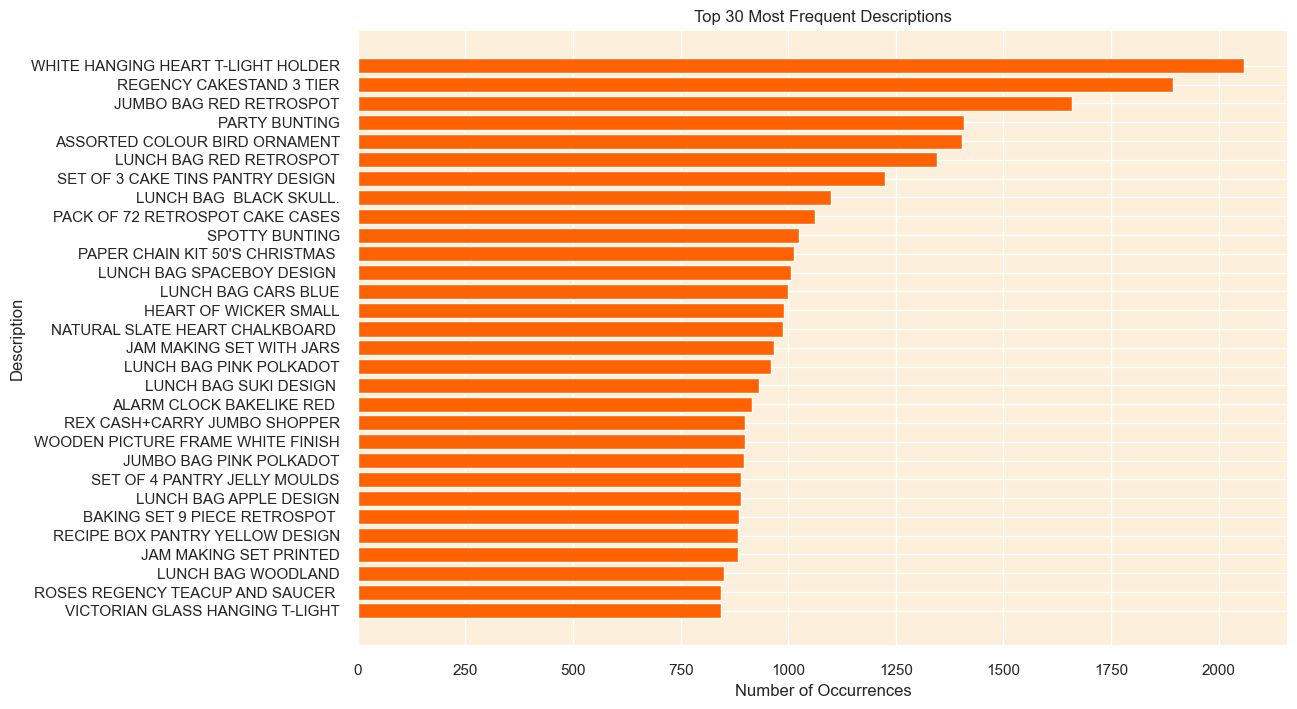

In [30]:
#calculate the occurence of each unique description and sort them 

description_counts =df["Description"].value_counts()
#get the top 30 description 

top_30_description=description_counts[:30]

#plotting 

plt.figure(figsize=(12,8))
plt.barh(top_30_description.index[::-1],top_30_description.values[::-1],color="#ff6200")


# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

The most frequent descriptions are generally household items, particularly those associated with kitchenware, lunch bags, and decorative items.

Interestingly, all the descriptions are in uppercase, which might be a standardized format for entering product descriptions in the database. However, considering the inconsistencies and anomalies encountered in the dataset so far, it would be prudent to check if there are descriptions entered in lowercase or a mix of case styles.

In [31]:
#find Unique descriptions containing lowercase characters 

lower_case_description=df["Description"].unique()
lower_case_description=[desc for desc in lower_case_description if any(char.islower() for char in desc)]

print("the unique description containing lowercase characters are:")
print('-'*10)
for desc in lower_case_description:
    print(desc)

the unique description containing lowercase characters are:
----------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


Upon reviewing the descriptions that contain lowercase characters, it is evident that some entries are not product descriptions, such as "Next Day Carriage" and "High Resolution Image". These entries seem to be unrelated to the actual products and might represent other types of information or service details.

Step 1: Remove the rows where the descriptions contain service-related information like "Next Day Carriage" and "High Resolution Image", as these do not represent actual products and would not contribute to the clustering and recommendation system we aim to build.

Step 2: For the remaining descriptions with mixed case, standardize the text to uppercase to maintain uniformity across the dataset. This will also assist in reducing the chances of having duplicate entries with different case styles.

By implementing the above strategy, we can enhance the quality of our dataset, making it more suitable for the analysis and modeling phases of our project.

In [32]:
service_related_description=["Next Day Carriage","High Resolution Image"]

#calculet the percentage of records with service-related descriptions

service_related_percentage=df[df['Description'].isin(service_related_description)].shape[0]/df.shape[0] *100

print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

#remove rows with service-related information in the description 

df=df[~df['Description'].isin(service_related_description)]

#standardize the text to upper case to maintain uniformity across the dataset

df["Description"]=df["Description"].str.upper() 



The percentage of records with service-related descriptions in the dataset is: 0.02%


In [33]:
df.shape[0]

399606

**Treating Zero Unit Prices**

In this step, first I am going to take a look at the statistical description of the UnitPrice column:



In [34]:
df["UnitPrice"].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

The minimum unit price value is zero. This suggests that there are some transactions where the unit price is zero, potentially indicating a free item or a data entry error. To understand their nature, it is essential to investigate these zero unit price transactions further. A detailed analysis of the product descriptions associated with zero unit prices will be conducted to determine if they adhere to a specific pattern:

In [35]:
df[df["UnitPrice"]==0].describe()[["Quantity"]]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


The transactions with a unit price of zero are relatively few in number (33 transactions).

These transactions have a large variability in the quantity of items involved, ranging from 1 to 12540, with a substantial standard deviation.

Including these transactions in the clustering analysis might introduce noise and could potentially distort the customer behavior patterns identified by the clustering algorithm.

Given the small number of these transactions and their potential to introduce noise in the data analysis, the strategy should be to remove these transactions from the dataset. This would help in maintaining a cleaner and more consistent dataset, which is essential for building an accurate and reliable clustering model and recommendation system.

In [36]:
#removing record with a unit price of zero to avoid potential data entry errors

df=df[df['UnitPrice']>0]

**Outlier Treatment**

In K-means clustering, the algorithm is sensitive to both the scale of data and the presence of outliers, as they can significantly influence the position of centroids, potentially leading to incorrect cluster assignments. However, considering the context of this project where the final goal is to understand customer behavior and preferences through K-means clustering, it would be more prudent to address the issue of outliers after the feature engineering phase where we create a customer-centric dataset. At this stage, the data is transactional, and removing outliers might eliminate valuable information that could play a crucial role in segmenting customers later on. Therefore, we will postpone the outlier treatment and proceed to the next stage for now.

In [37]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,Completed
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,Completed
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,Completed
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,Completed


In [38]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [39]:
df.shape[0]

399573

**Feature Engineering**

In order to create a comprehensive customer-centric dataset for clustering and recommendation, the following features can be engineered from the available data


**RFM Features**

RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:

**Recency (R)**: This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.

**Frequency (F)**: This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.

**Monetary (M)**: This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

Together, these metrics help in understanding a customer's buying behavior and preferences, which is pivotal in personalizing marketing strategies and creating a recommendation system.


**Recency(R)**

In this step, we focus on understanding how recently a customer has made a purchase. This is a crucial aspect of customer segmentation as it helps in identifying the engagement level of customers. Here, I am going to define the following feature:

**Days Since Last Purchase**: This feature represents the number of days that have passed since the customer's last purchase. A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement. By understanding the recency of purchases, businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.


In [40]:
#convert InvoiceDate to datetime type 

df["InvoiceDate"]=pd.to_datetime(df["InvoiceDate"])

df["InvoiceDay"]=df["InvoiceDate"].dt.date

In [41]:
#find the most recent purchase date for each customer 

customer_data=df.groupby("CustomerID")["InvoiceDay"].max().reset_index()

most_recent_date=df["InvoiceDay"].max()

#convert Invoicedat to datetme type before substraction

customer_data["InvoiceDay"]=pd.to_datetime(customer_data["InvoiceDay"])

most_recent_date=pd.to_datetime(most_recent_date)

#calculate the number of days since the last purchase for each customer 
customer_data["Days_since_last_purchase"]=(most_recent_date-customer_data["InvoiceDay"]).dt.days


#remove the Invoiceday column 
customer_data.drop(columns=["InvoiceDay"],inplace=True)


In [42]:
customer_data.head()

,CustomerID,Days_since_last_purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


**Frequency(F)**

In this step, I am going to create two features that quantify the frequency of a customer's engagement with the retailer:

**Total Transactions**: This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.

**Total Products Purchased**: This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

These features will be crucial in segmenting customers based on their buying frequency, which is a key aspect in determining customer segments for targeted marketing and personalized recommendations.

In [43]:
#calculate the total number of tranasctions made by each customer 

total_tranasction=df.groupby("CustomerID")["InvoiceNo"].nunique().reset_index()
total_tranasction.rename(columns={"InvoiceNo": "Total_transaction"},inplace=True)

#calculate the total number of purchased product by each customer 

total_product_purchased=df.groupby("CustomerID")["Quantity"].sum().reset_index()
total_product_purchased.rename(columns={"Quantity":"Total_purchased"},inplace=True)

#merge the new features into customer_data dataframe 

customer_data=pd.merge(customer_data,total_tranasction,on='CustomerID')
customer_data=pd.merge(customer_data,total_product_purchased,on="CustomerID")

#display few rows 
customer_data.head()



,CustomerID,Days_since_last_purchase,Total_transaction,Total_purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


**Monetary(M)**

In this step, I am going to create two features that represent the monetary aspect of customer's transactions:

**Total Spend**: This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.

**Average Transaction Value**: This feature is calculated as the Total Spend divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.

In [44]:
#calculate the total spend by each customer

df["Total_Spend"]=df["UnitPrice"]*df["Quantity"]

total_spend=df.groupby("CustomerID")["Total_Spend"].sum().reset_index()

#Calculate the average transaction value for each customer 

average_tranasction_value=total_spend.merge(total_tranasction,on="CustomerID")
#average_tranasction_value
average_tranasction_value["Average_Transaction_Value"]=average_tranasction_value['Total_Spend']/average_tranasction_value["Total_transaction"]



In [45]:
#merge the new features into customer dataframe 

customer_data=pd.merge(customer_data,total_spend,on="CustomerID")
customer_data=pd.merge(customer_data,average_tranasction_value[['CustomerID','Average_Transaction_Value']],on="CustomerID")

customer_data.head()


,CustomerID,Days_since_last_purchase,Total_transaction,Total_purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


**Product Diversity**

In this step, we are going to understand the diversity in the product purchase behavior of customers. Understanding product diversity can help in crafting personalized marketing strategies and product recommendations. Here, I am going to define the following feature:

Unique Products Purchased: This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.


In [46]:
# calculate the number of unique products purchased by each customer

unique_product_purchased=df.groupby('CustomerID')['StockCode'].nunique().reset_index()

unique_product_purchased.rename(columns={"StockCode":'Unique_product_purchased'},inplace=True)

In [47]:
#Merge the new feature into the customer_data dataframe 

customer_data=pd.merge(customer_data,unique_product_purchased, on='CustomerID')

#Display the first few rows of the customer_data dataframe 

In [48]:
customer_data.head()

,CustomerID,Days_since_last_purchase,Total_transaction,Total_purchased,Total_Spend,Average_Transaction_Value,Unique_product_purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


**Behavioral Features**

In this step, we aim to understand and capture the shopping patterns and behaviors of customers. These features will give us insights into the customers' preferences regarding when they like to shop, which can be crucial information for personalizing their shopping experience. Here are the features I am planning to introduce:

**Average Days Between Purchases**: This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.

**Favorite Shopping Day**: This denotes the day of the week when the customer shops the most. This information can help in identifying the preferred shopping days of different customer segments, which can be used to optimize marketing strategies and promotions for different days of the week.

**Favorite Shopping Hour**: This refers to the hour of the day when the customer shops the most. Identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most active.

By including these behavioral features in our dataset, we can create a more rounded view of our customers, which will potentially enhance the effectiveness of the clustering algorithm, leading to more meaningful customer segments.

In [50]:
#Extract day of week and hour from InvoiceDate

df['Day_of_week']=df["InvoiceDate"].dt.dayofweek
df["Hour"]=df["InvoiceDate"].dt.hour

#calculate the average number of days between consecutive purchases

days_between_purchases=df.groupby("CustomerID")["InvoiceDay"].apply(lambda x:(x.diff().dropna()).apply(lambda y:y.days))
average_days_between_purchases=days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay':"Average_days_between_purchases"},inplace=True)

# find the favorite shopping day of the week 
favorite_shopping_day=df.groupby(['CustomerID','Day_of_week']).size().reset_index(name="Count")
favorite_shopping_day=favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][["CustomerID","Day_of_week"]]

#find the favorite shopping hour of the day
favourite_shopping_hour=df.groupby(["CustomerID","Hour"]).size().reset_index(name="Count")
favourite_shopping_hour=favourite_shopping_hour.loc[favourite_shopping_hour.groupby("CustomerID")["Count"].idxmax()][["CustomerID","Hour"]]

#merge the new features into the customer_Data dataframe 
customer_data=pd.merge(customer_data,average_days_between_purchases,on='CustomerID')
customer_data=pd.merge(customer_data,favorite_shopping_day,on="CustomerID")
customer_data=pd.merge(customer_data,favourite_shopping_hour,on="CustomerID")

customer_data.head()

,CustomerID,Days_since_last_purchase,Total_transaction,Total_purchased,Total_Spend,Average_Transaction_Value,Unique_product_purchased,Average_days_between_purchases,Day_of_week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


**Geographic Features**

In this step, we will introduce a geographic feature that reflects the geographical location of customers. Understanding the geographic distribution of customers is pivotal for several reasons:

**Country**: This feature identifies the country where each customer is located. Including the country data can help us understand region-specific buying patterns and preferences. Different regions might have varying preferences and purchasing behaviors which can be critical in personalizing marketing strategies and inventory planning. Furthermore, it can be instrumental in logistics and supply chain optimization, particularly for an online retailer where shipping and delivery play a significant role.

In [51]:
df["Country"].value_counts(normalize=True).head()

Country
United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: proportion, dtype: float64

Given that a substantial portion (89%) of transactions are originating from the United Kingdom, we might consider creating a binary feature indicating whether the transaction is from the UK or not. This approach can potentially streamline the clustering process without losing critical geographical information, especially when considering the application of algorithms like K-means which are sensitive to the dimensionality of the feature space.

Methodology:

First, I will group the data by CustomerID and Country and calculate the number of transactions per country for each customer.

Next, I will identify the main country for each customer (the country from which they have the maximum transactions).

Then, I will create a binary column indicating whether the customer is from the UK or not.

Finally, I will merge this information with the customer_data dataframe to include the new feature in our analysis.

In [52]:
#group by customerID and Country to get the number of transactions per country for each customer 

customer_country=df.groupby(['CustomerID','Country']).size().reset_index(name='Number_of_Transactions')

#get the country with the maximum number of transactions for each customer
customer_main_country=customer_country.sort_values('Number_of_Transactions',ascending=False).drop_duplicates("CustomerID")

#Create a binary column indicating whether the customer is from the uk or not 

customer_main_country["Is_UK"]=customer_main_country["Country"].apply(lambda x: 1 if x=="United Kingdom" else 0)

#merge this data with our customer_data dataframe 
customer_data=pd.merge(customer_data,customer_main_country[["CustomerID","Is_UK"]],on="CustomerID",how="left")

customer_data.head()

,CustomerID,Days_since_last_purchase,Total_transaction,Total_purchased,Total_Spend,Average_Transaction_Value,Unique_product_purchased,Average_days_between_purchases,Day_of_week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [53]:
customer_data["Is_UK"].value_counts()

Is_UK
1    3866
0     416
Name: count, dtype: int64

In this step, I am going to delve deeper into the cancellation patterns of customers to gain insights that can enhance our customer segmentation model. The features I am planning to introduce are:

**Cancellation Frequency**: This metric represents the total number of transactions a customer has canceled. Understanding the frequency of cancellations can help us identify customers who are more likely to cancel transactions. This could be an indicator of dissatisfaction or other issues, and understanding this can help us tailor strategies to reduce cancellations and enhance customer satisfaction.

**Cancellation Rate**: This represents the proportion of transactions that a customer has canceled out of all their transactions. This metric gives a normalized view of cancellation behavior. A high cancellation rate might be indicative of an unsatisfied customer segment. By identifying these segments, we can develop targeted strategies to improve their shopping experience and potentially reduce the cancellation rate.

By incorporating these cancellation insights into our dataset, we can build a more comprehensive view of customer behavior, which could potentially aid in creating more effective and nuanced customer segmentation.

In [54]:
#calculate the total number of transactions made by each customer 
total_tranasctions=df.groupby("CustomerID")["InvoiceNo"].nunique().reset_index()

#calculete the number of cancelled transaction for each customer
cancelled_transactions=df[df['Transaction_status']=='Cancelled']
cancelled_frequency=cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancelled_frequency.rename(columns={'InvoiceNo':'Cancellation_Frequency'},inplace=True)

#merge the cancellation frequency data into the customer_data dataframe
customer_data=pd.merge(customer_data,cancelled_frequency,on="CustomerID",how="left")

#replace NaN values with 0(for customer who have not cancelled any transaction)
customer_data["Cancellation_Frequency"].fillna(0,inplace=True)

# calculate the cancellation rate.
customer_data['Cancellation_Rate']=customer_data["Cancellation_Frequency"]/total_tranasctions["InvoiceNo"]

customer_data.head()

,CustomerID,Days_since_last_purchase,Total_transaction,Total_purchased,Total_Spend,Average_Transaction_Value,Unique_product_purchased,Average_days_between_purchases,Day_of_week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


**Seasonality & Trends**


In this step, I will delve into the seasonality and trends in customers' purchasing behaviors, which can offer invaluable insights for tailoring marketing strategies and enhancing customer satisfaction. Here are the features I am looking to introduce:

Monthly_Spending_Mean: This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.

Monthly_Spending_Std: This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more.

Spending_Trend: This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction. Conversely, a negative trend might signal decreasing interest or satisfaction, highlighting a need for re-engagement strategies. A near-zero value signifies stable spending habits. Recognizing these trends can help in developing strategies to either maintain or alter customer spending patterns, enhancing the effectiveness of marketing campaigns.

By incorporating these detailed insights into our customer segmentation model, we can create more precise and actionable customer groups, facilitating the development of highly targeted marketing strategies and promotions.

In [55]:
#Extract Month and year from InvoiceDate

df["Year"]=df["InvoiceDate"].dt.year
df['Month']=df["InvoiceDate"].dt.month

#calculate monthly spending for each customer 
monthly_spending=df.groupby(["CustomerID","Year","Month"])["Total_Spend"].sum().reset_index()

#calculate seasonal Buying Patterns:  we are using monthly frequency as a proxy for seasonal buying patterns

seasonal_buying_patterns=monthly_spending.groupby('CustomerID')["Total_Spend"].agg(['mean','std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean':'Monthly_spending_mean','std':"Monthly_spending_std"},inplace=True)

#Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month

seasonal_buying_patterns["Monthly_spending_std"].fillna(0,inplace=True)

#calculate Trends in spending
# we are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends

def calculate_trend(spend_data):
    #if there are more than one data points, we calculate the trend using linear regression
    if len(spend_data)>1:
        x=np.arange(len(spend_data))
        slope,intercept,r_value,p_value,error=linregress(x,spend_data)
        return slope 
    else:
        return 0
    
#apply the calculate_trend function to find the spending trend for each customer 

spending_trends=monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend':'Spending_Trend'},inplace=True)

#merge the new features into the customer_data dataframe
customer_data=pd.merge(customer_data,seasonal_buying_patterns,on='CustomerID')
customer_data=pd.merge(customer_data,spending_trends,on="CustomerID")

customer_data.head()


,CustomerID,Days_since_last_purchase,Total_transaction,Total_purchased,Total_Spend,Average_Transaction_Value,Unique_product_purchased,Average_days_between_purchases,Day_of_week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_spending_mean,Monthly_spending_std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


Positive slope → spending increasing

Negative slope → spending decreasing

Near-zero → no trend

In [56]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [ ]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_since_last_purchase        4282 non-null   Int64  
 2   Total_transaction               4282 non-null   Int64  
 3   Total_purchased                 4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_product_purchased        4282 non-null   Int64  
 7   Average_days_between_purchases  4282 non-null   Float64
 8   Day_of_week                     4282 non-null   Int32  
 9   Hour                            4282 non-null   Int32  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

In [57]:
customer_data.head(10)


,CustomerID,Days_since_last_purchase,Total_transaction,Total_purchased,Total_Spend,Average_Transaction_Value,Unique_product_purchased,Average_days_between_purchases,Day_of_week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_spending_mean,Monthly_spending_std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
5,12352.0,36,8,463,1265.41,158.17625,57,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351
6,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
7,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
8,12355.0,214,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635


Let's review the descriptions of the columns in our newly created customer_data dataset:

Customer Dataset Description:

**CustomerID**:Identifier uniquely assigned to each customer, used to distinguish individual customers.

**Days_Since_Last_Purchase**:The number of days that have passed since the customer's last purchase.

**Total_Transactions**:	The total number of transactions made by the customer.
Total_Products_Purchased	The total quantity of products purchased by the customer across all transactions.

**Total_Spend**:The total amount of money the customer has spent across all transactions.

**Average_Transaction_Value**:The average value of the customer's transactions, calculated as total spend divided by the number of transactions.

**Unique_Products_Purchased**:The number of different products the customer has purchased.

**Average_Days_Between_Purchases**:	The average number of days between consecutive purchases made by the customer.

**Day_Of_Week**:The day of the week when the customer prefers to shop, represented numerically (0 for Monday, 6 for Sunday).

**Hour**: The hour of the day when the customer prefers to shop, represented in a 24-hour format.

**Is_UK**:	A binary variable indicating whether the customer is based in the UK (1) or not (0).

**Cancellation_Frequency**:	The total number of transactions that the customer has cancelled.

**Cancellation_Rate**:	The proportion of transactions that the customer has cancelled, calculated as cancellation frequency divided by total transactions.

**Monthly_Spending_Mean**:The average monthly spending of the customer.

**Monthly_Spending_Std**:The standard deviation of the customer's monthly spending, indicating the variability in their spending pattern.

**Spending_Trend**:	A numerical representation of the trend in the customer's spending over time. A positive value indicates an increasing trend, a negative value indicates a decreasing trend, and a value close to zero indicates a stable trend.




Now that our dataset is ready, we can move on to the next steps of our project. This includes looking at our data more closely to find any patterns or trends, making sure our data is in the best shape by checking for and handling any outliers, and preparing our data for the clustering process. All of these steps will help us build a strong foundation for creating our customer segments and, eventually, a personalized recommendation system.

**Outlier Detection and Treatment**

In this section, I will identify and handle outliers in our dataset. Outliers are data points that are significantly different from the majority of other points in the dataset. These points can potentially skew the results of our analysis, especially in k-means clustering where they can significantly influence the position of the cluster centroids. Therefore, it is essential to identify and treat these outliers appropriately to achieve more accurate and meaningful clustering results.

Given the multi-dimensional nature of the data, it would be prudent to use algorithms that can detect outliers in multi-dimensional spaces. I am going to use the Isolation Forest algorithm for this task. This algorithm works well for multi-dimensional data and is computationally efficient. It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

In [59]:
model=IsolationForest(contamination=0.05,random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data["Outlier_scores"]=model.fit_predict(customer_data.iloc[:,1:].to_numpy())

#Creating a column to identify outlier(1 for inlier and -1 for outlier)
customer_data["Is_outlier"]=[1 if x==-1 else 0 for x in customer_data["Outlier_scores"]]

#display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_since_last_purchase,Total_transaction,Total_purchased,Total_Spend,Average_Transaction_Value,Unique_product_purchased,Average_days_between_purchases,Day_of_week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_spending_mean,Monthly_spending_std,Spending_Trend,Outlier_scores,Is_outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


Now let's visualize the distribution of these scores and the number of inliers and outliers detected by the model

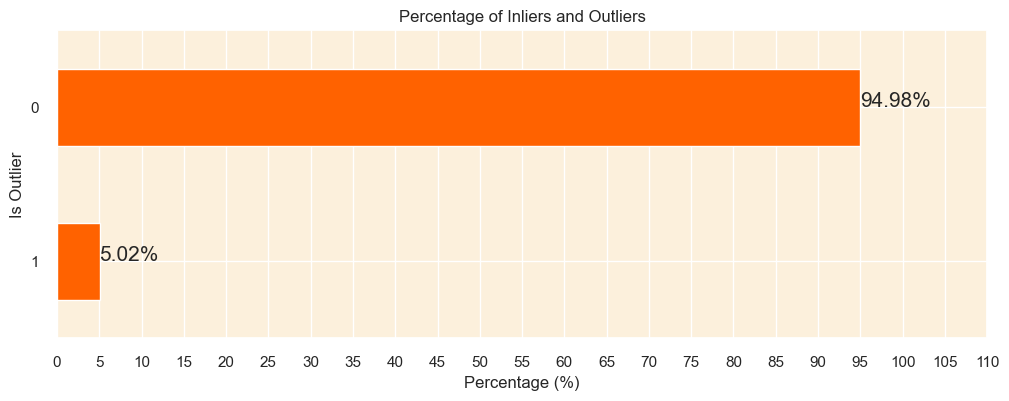

In [61]:
#calculate the percentage of inliers and outliers

outlier_percentage=customer_data["Is_outlier"].value_counts(normalize=True)*100

#plotting the graph
plt.figure(figsize=(12,4))
outlier_percentage.plot(kind="barh",color="#ff6200")

#adding the percentage labels on the bars 
for index, value in enumerate(outlier_percentage):
    plt.text(value,index,f'{value:.2f}%',fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

From the above plot, we can observe that about 5% of the customers have been identified as outliers in our dataset. This percentage seems to be a reasonable proportion, not too high to lose a significant amount of data, and not too low to retain potentially noisy data points. It suggests that our isolation forest algorithm has worked well in identifying a moderate percentage of outliers, which will be critical in refining our customer segmentation.

Considering the nature of the project (customer segmentation using clustering), it is crucial to handle these outliers to prevent them from affecting the clusters' quality significantly. Therefore, I will separate these outliers for further analysis and remove them from our main dataset to prepare it for the clustering analysis.

Let's proceed with the following steps:

Separate the identified outliers for further analysis and save them as a separate file (optional).

Remove the outliers from the main dataset to prevent them from influencing the clustering process.

Drop the Outlier_Scores and Is_Outlier columns as they were auxiliary columns used for the outlier detection process.

Let's implement these steps: